Your goal is to create two game-playing agents that will compete against each other in two
player Pong. The agents should be trained from zero-knowledge in an unsupervised fashion.
That is, no game-playing knowledge or strategies may be hard coded, and no training dataset is
required. Additionally, the two agents must be trained simultaneously. If you choose this option,
please submit two trained models (one for each player).

In [42]:
%matplotlib inline
import pylab as plt
import gym
import numpy as np
import rl 
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import ModelIntervalCheckpoint,TrainEpisodeLogger,TestLogger,Callback
import keras
#from tensorflow import keras
from IPython.display import clear_output
import time
#import ma_gym
from rl.core import Processor
from PIL import Image

In [55]:
# create test callback that records the image output 
class TestLogger_w_outputs(Callback):
    """ Logger Class for Test """
    def __init__(self):
        # Some algorithms compute multiple episodes at once since they are multi-threaded.
        # We therefore use a dictionary that is indexed by the episode to separate episodes
        # from each other.
        self.episode_start = {}
        self.observations = {}
        self.rewards = {}
        self.actions = {}
        self.metrics = {}
        self.step = 0
        
    def on_episode_begin(self, episode, logs):
        """ Reset environment variables at beginning of each episode """
        self.episode_start[episode] = 0
        self.observations[episode] = []
        self.rewards[episode] = []
        #self.actions[episode] = []
        #self.metrics[episode] = []

    def on_episode_end(self, episode, logs):
        """ Print logs at end of each episode """
        template = 'Episode {0}: reward: {1:.3f}, steps: {2}'
        variables = [
            episode + 1,
            logs['episode_reward'],
            logs['nb_steps'],
        ]
        print(template.format(*variables))
        
    def on_step_end(self, step, logs):
        """ Update statistics of episode after each step """
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        #self.actions[episode].append(logs['action'])
        #self.metrics[episode].append(logs['metrics'])
        self.step += 1

In [24]:
# helper to claculate moving average
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


# Play game against random agents

Create a baseline metric 

In [69]:
# show games
show_game = False

In [76]:
n_episodes = 100
total_run = []
env = gym.make('Pong-v0')
agent_1_reward = dict()
# run for number of episodes
for i in range(n_episodes):
    env.reset()
    rounds = 0
    # run for a round with unknown amount of steps
    while True: 
        action_1 = env.action_space.sample()
        observation, reward, done,info = env.step(action_1)
        clear_output(wait=True)
        # show game
        if show_game:
            plt.imshow(observation)
            plt.show() 
        # save reward
        if reward != 0 :
            if i not in agent_1_reward:
                agent_1_reward[i] = 0
            agent_1_reward[i] += reward
        # print results at end of round
        if done:
            print('round',rounds,'episode',i,'Agent reward = {}'.format(agent_1_reward[i]) )
            break
        rounds += 1

KeyboardInterrupt: 

In [28]:
moving_average(list(agent_1_reward.values()),50)

array([-20.48, -20.46, -20.46, -20.46, -20.4 , -20.38, -20.4 , -20.46,
       -20.44, -20.44, -20.46, -20.46, -20.46, -20.46, -20.44, -20.38,
       -20.32, -20.3 , -20.3 , -20.3 , -20.26, -20.22, -20.24, -20.18,
       -20.16, -20.16, -20.16, -20.14, -20.16, -20.12, -20.1 , -20.1 ,
       -20.1 , -20.12, -20.12, -20.08, -20.06, -20.06, -20.04, -20.04,
       -20.02, -19.98, -19.94, -19.98, -19.98, -19.98, -19.98, -19.96,
       -19.94, -19.94, -19.98])

Text(0, 0.5, 'Avg Reward')

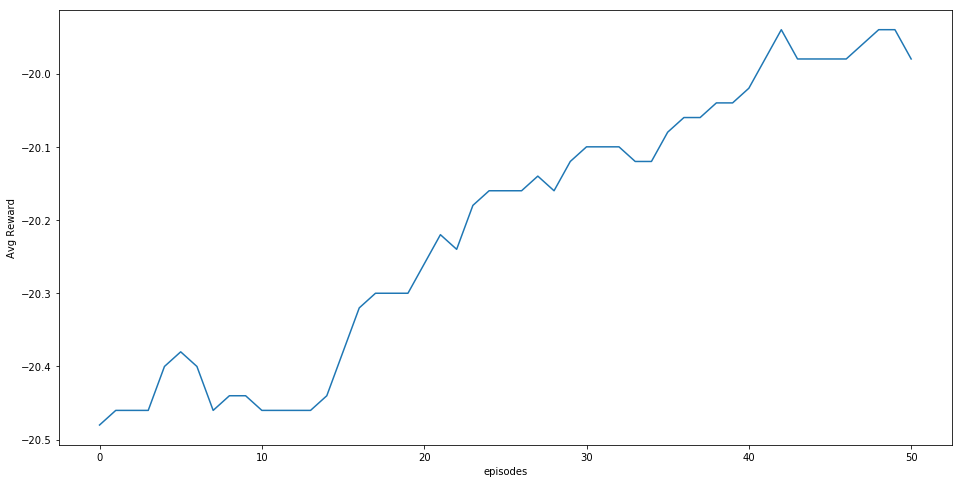

In [62]:
# plot rewards
fig,*ax = plt.subplots(1,1,sharey=True, figsize=(16,8))
ax= np.ravel(ax)
ax[0].plot(moving_average(list(agent_1_reward.values()),50))
ax[0].set_xlabel('episodes')
ax[0].set_ylabel('Avg Reward')

# Try with Q learning agents

In [30]:
# look at action space
env = gym.make('Pong-v0')
obs= env.reset()
obs.shape

(210, 160, 3)

In [85]:
# Do image shape reduction and reduce memory needed for history

INPUT_SHAPE = (64, 64)

class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)
    
    def process_action(self, action):
        """Processes an action predicted by an agent but before execution in an environment.
        # Arguments
            action (int): Action given to the environment
        # Returns
            Processed action given to the environment
        Actions seem to map to    
        0,1 nothing
        2,4 up
        3,5 down    
        """
        # nothing
        if action == 0 :
            return 0
        # up
        elif  action == 2:
            return 2
        # Down
        elif action == 1:
            return 3

In [86]:
# keras model
action_space = np.zeros(3)
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=(8,) +INPUT_SHAPE))
# make channels first
model.add(keras.layers.Permute((2, 3, 1)))
model.add(keras.layers.Convolution2D(16, (8, 8), padding='same',activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Convolution2D(32, (4, 4), padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Convolution2D(64, (2, 2), padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='linear'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_5 (Permute)          (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 16)        8208      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        8224      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 8, 64)         

In [88]:
# RL model
# define memory
memory = SequentialMemory(limit=10000, window_length=8)
# search policy with anneling schedual
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,nb_steps=100000)
processor = AtariProcessor()
# get number of actions
nb_actions = 3 #env.action_space.n
# create agent
dqn = DQNAgent(model=model, nb_actions=nb_actions, policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=10000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
dqn.compile('Adam', metrics=['mae'])

In [ ]:
# train do save every 50k steps
checkpoint_weights_filename = 'dqn_' + 'pong' + '_weights_{step}.h5f'
#log_filename = 'dqn_{}_log.json'.format(args.env_name)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=50000)]
dqn.fit(env, nb_steps=10**6, callbacks=callbacks,verbose=True)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 55s 6ms/step - reward: -0.0154
7 episodes - episode_reward: -20.857 [-21.000, -20.000] - ale.lives: 0.000

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 622s 62ms/step - reward: -0.0145
7 episodes - episode_reward: -20.571 [-21.000, -19.000] - loss: 0.010 - mae: 0.068 - mean_q: -0.064 - mean_eps: 0.865 - ale.lives: 0.000

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 631s 63ms/step - reward: -0.0168
8 episodes - episode_reward: -20.875 [-21.000, -20.000] - loss: 0.008 - mae: 0.078 - mean_q: -0.098 - mean_eps: 0.775 - ale.lives: 0.000

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 653s 65ms/step - reward: -0.0167
8 episodes - episode_reward: -20.875 [-21.000, -20.000] - loss: 0.008 - mae: 0.087 - mean_q: -0.111 - mean_eps: 0.685 - ale.lives: 0.000

Interval 5 (40000 steps p

# Test Agent

In [35]:
# load saved weights
dqn.load_weights('dqn_pong_weights_1000000.h5f')
dqn.compile('Adam', metrics=['mae'])

In [63]:
# run match
# saves the images from the matches
test_logger= TestLogger_w_outputs()
# run
hist = dqn.test(env, nb_episodes=100,visualize=False, callbacks=[test_logger])

Testing for 100 episodes ...
Episode 1: reward: -21.000, steps: 1017
Episode 1: reward: -21.000, steps: 1017
Episode 2: reward: -21.000, steps: 1012
Episode 2: reward: -21.000, steps: 1012
Episode 3: reward: -21.000, steps: 1017
Episode 3: reward: -21.000, steps: 1017
Episode 4: reward: -21.000, steps: 1018
Episode 4: reward: -21.000, steps: 1018
Episode 5: reward: -21.000, steps: 1018
Episode 5: reward: -21.000, steps: 1018
Episode 6: reward: -21.000, steps: 1015
Episode 6: reward: -21.000, steps: 1015
Episode 7: reward: -21.000, steps: 1017
Episode 7: reward: -21.000, steps: 1017
Episode 8: reward: -21.000, steps: 1008
Episode 8: reward: -21.000, steps: 1008
Episode 9: reward: -21.000, steps: 1025
Episode 9: reward: -21.000, steps: 1025
Episode 10: reward: -21.000, steps: 1028
Episode 10: reward: -21.000, steps: 1028
Episode 11: reward: -21.000, steps: 1022
Episode 11: reward: -21.000, steps: 1022
Episode 12: reward: -21.000, steps: 1017
Episode 12: reward: -21.000, steps: 1017
Episo

In [50]:
# play match
for episode in test_logger.observations:
    for steps in test_logger.observations[episode]:
        clear_output(wait=True)
        plt.imshow(steps)
        plt.show() 

KeyboardInterrupt: 

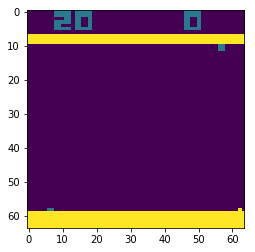

In [66]:
# show final score if impatent
plt.imshow(test_logger.observations[episode][-1])

Text(0, 0.5, 'Avg Reward')

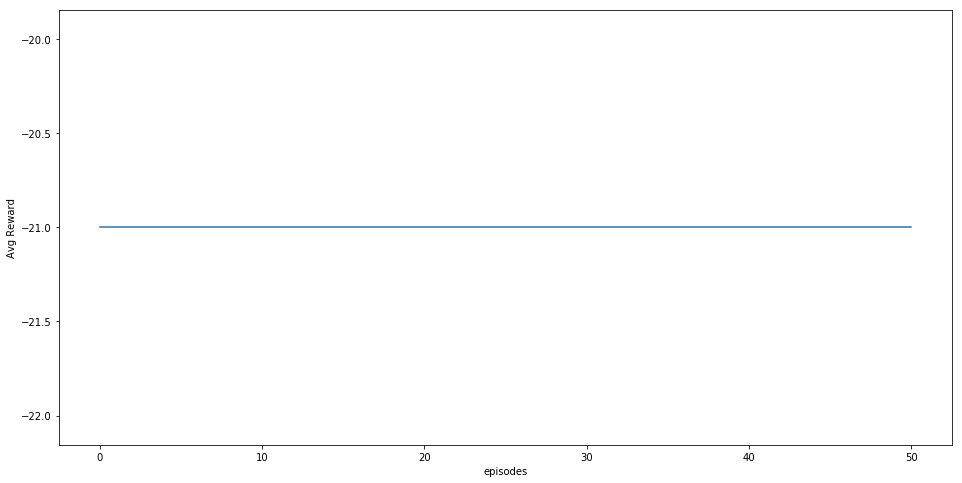

In [67]:
# plot reward
# plot rewards
fig,*ax = plt.subplots(1,1,sharey=True, figsize=(16,8))
ax= np.ravel(ax)
ax[0].plot(moving_average(list(map(sum,test_logger.rewards.values())),50))
ax[0].set_xlabel('episodes')
ax[0].set_ylabel('Avg Reward')